<a href="https://colab.research.google.com/github/prachi735/EVA5_2/blob/main/SuperConvergance/EVA5_S11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import files from github

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
! pip install -U albumentations
! git clone https://github.com/prachi735/EVA5_2

Requirement already up-to-date: albumentations in /usr/local/lib/python3.7/dist-packages (0.5.2)
fatal: destination path 'EVA5_2' already exists and is not an empty directory.


In [ ]:
%cd EVA5_2/SuperConvergance/
! git pull

/content/EVA5_2/SuperConvergance
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/prachi735/EVA5_2
   6aa69d4..0eef1d2  main       -> origin/main
Updating 6aa69d4..0eef1d2
Fast-forward
 SuperConvergance/customResnet.py |  2 +-
 SuperConvergance/lr_finder.py    | 24 +++++++++++++++++++++++-
 2 files changed, 24 insertions(+), 2 deletions(-)


In [ ]:
from dataset import *
from utils import *
from customResnet import *
from model import *
from test import *
from train import *
from model_utils import *
from transforms import *
from gradcam import get_gradcam
from lr_finder import LRFinder
from torchvision.utils  import make_grid, save_image
import PIL

# Data

Files already downloaded and verified
Files already downloaded and verified
torch.Size([512, 3, 32, 32])


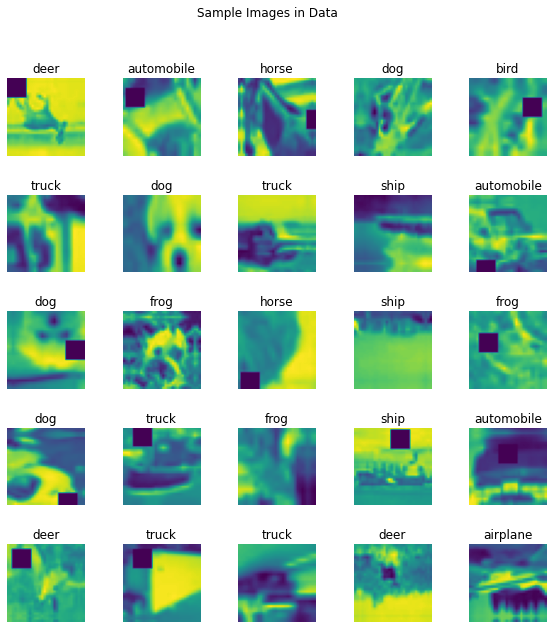

In [ ]:
dataset_name = 'CIFAR10'
#normalization:
mean=[0.4914, 0.4822, 0.4465]
std=[0.247, 0.243, 0.261]

train_transforms,test_transforms = get_album_transforms(mean, std)
train_data = Cifar10AlbuDataset(root='./data', train=True, download=True, transform=train_transforms)
test_data = Cifar10AlbuDataset(root='./data', train=False, download=True, transform=test_transforms)

classes=train_data.classes

seed_everything()
device = get_device()

train_loader = get_dataloader(train_data,batch_size=512)
test_loader = get_dataloader(test_data, shuffle=False)
#plot_sample_images(train_loader, classes, ncols=5, nrows=5, fig_size=(2,2))

# Train Model

## Model Arch

In [ ]:
model = Custom_ResNet().to(device)
#model =  myResNet().to(device)
print(get_model_summary(model))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

## LR Finder

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-04, momentum=0.9,weight_decay=1e-4)

In [ ]:
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_loader,  end_lr=1, num_iter=len(train_loader), step_mode="exp", val_loader=test_loader)

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 3.05E-03


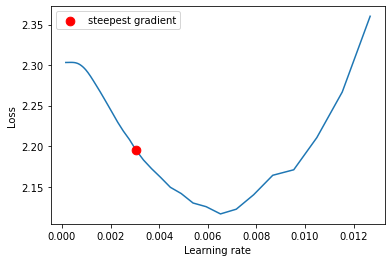

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb2a49c3810>,
 0.0030516595595401815)

In [ ]:
lr_finder.plot(log_lr=False,skip_start=5,skip_end=5)

In [ ]:
suggested_lr = lr_finder.get_suggested_lr()
print(suggested_lr)

0.006522783886743435
0.0030516595595401815


In [ ]:
lr_finder.reset()

## Train the model

In [ ]:
EPOCHS = 24
MAX_AT_EPOCH = 5
optimizer = optim.SGD(model.parameters(), lr=suggested_lr, momentum=0.9,weight_decay=1e-4)
scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr = suggested_lr*4, total_steps=None, epochs=EPOCHS, steps_per_epoch=len(train_loader), 
                       pct_start=MAX_AT_EPOCH/EPOCHS, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, max_momentum=0.95
                       ,div_factor=25,final_div_factor =.9
                       )
train_losses = []
train_acc = []
test_losses = []
test_acc = []
lrs = []

best_test_acc = 0
model_path = 'session11_model.pth'


In [ ]:
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    #train
    train_epoch_acc,train_epoch_loss = train(model, device, train_loader, optimizer, scheduler, criterion)
    train_losses.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)

    #test
    test_epoch_acc,test_epoch_loss = test(model, device, test_loader, criterion)
    test_losses.append(test_epoch_loss)
    test_acc.append(test_epoch_acc)

    # remember best accuracy and save the model
    is_best = test_epoch_acc > best_test_acc
    best_test_acc = max(test_epoch_acc, best_test_acc)
    
    if is_best:
      print('Saving Model for accuracy: ',test_epoch_acc)
      torch.save(model.state_dict(), model_path) 

    lrs.append(scheduler.get_last_lr())

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1


Loss=0.2514050602912903 Batch_id=97 Accuracy=90.14: 100%|██████████| 98/98 [00:26<00:00,  3.72it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8870/10000 (88.70%)

Saving Model for accuracy:  88.7
EPOCH: 2


Loss=0.23964297771453857 Batch_id=97 Accuracy=90.00: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8799/10000 (87.99%)

EPOCH: 3


Loss=0.2800820767879486 Batch_id=97 Accuracy=89.33: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8804/10000 (88.04%)

EPOCH: 4


Loss=0.33447030186653137 Batch_id=97 Accuracy=89.09: 100%|██████████| 98/98 [00:26<00:00,  3.76it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8787/10000 (87.87%)

EPOCH: 5


  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8776/10000 (87.76%)

EPOCH: 6


Loss=0.3373260200023651 Batch_id=97 Accuracy=88.88: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8746/10000 (87.46%)

EPOCH: 7


Loss=0.352461576461792 Batch_id=97 Accuracy=88.80: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8782/10000 (87.82%)

EPOCH: 8


Loss=0.25241154432296753 Batch_id=97 Accuracy=88.86: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8719/10000 (87.19%)

EPOCH: 9


Loss=0.3548557162284851 Batch_id=97 Accuracy=89.16: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8779/10000 (87.79%)

EPOCH: 10


Loss=0.33942335844039917 Batch_id=97 Accuracy=88.99: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 8781/10000 (87.81%)

EPOCH: 11


Loss=0.3058771789073944 Batch_id=97 Accuracy=88.76: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8718/10000 (87.18%)

EPOCH: 12


Loss=0.33485570549964905 Batch_id=97 Accuracy=88.95: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8774/10000 (87.74%)

EPOCH: 13


Loss=0.3324436545372009 Batch_id=97 Accuracy=89.23: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8777/10000 (87.77%)

EPOCH: 14


Loss=0.2247665971517563 Batch_id=97 Accuracy=89.07: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8779/10000 (87.79%)

EPOCH: 15


Loss=0.23075607419013977 Batch_id=97 Accuracy=89.35: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8786/10000 (87.86%)

EPOCH: 16


Loss=0.2740373909473419 Batch_id=97 Accuracy=89.59: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8793/10000 (87.93%)

EPOCH: 17


Loss=0.371715247631073 Batch_id=97 Accuracy=89.55: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8846/10000 (88.46%)

EPOCH: 18


Loss=0.29599228501319885 Batch_id=97 Accuracy=89.89: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8809/10000 (88.09%)

EPOCH: 19


Loss=0.2647746205329895 Batch_id=97 Accuracy=90.05: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8825/10000 (88.25%)

EPOCH: 20


Loss=0.3183813691139221 Batch_id=97 Accuracy=90.32: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8859/10000 (88.59%)

EPOCH: 21


Loss=0.256388396024704 Batch_id=97 Accuracy=90.38: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8856/10000 (88.56%)

EPOCH: 22


Loss=0.2723540663719177 Batch_id=97 Accuracy=90.44: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8836/10000 (88.36%)

EPOCH: 23


Loss=0.3372970521450043 Batch_id=97 Accuracy=90.69: 100%|██████████| 98/98 [00:25<00:00,  3.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8874/10000 (88.74%)

Saving Model for accuracy:  88.74
EPOCH: 24


Loss=0.33694595098495483 Batch_id=97 Accuracy=90.72: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]



Test set: Average loss: 0.0034, Accuracy: 8884/10000 (88.84%)

Saving Model for accuracy:  88.84


In [41]:
print('BEST TEST ACCURACY:{}%'.format(max(test_acc)))

BEST TEST ACCURACY:88.84%


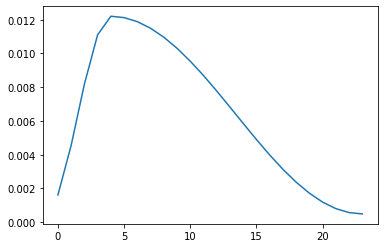

In [42]:
 plt.plot(lrs)

# View Model Results

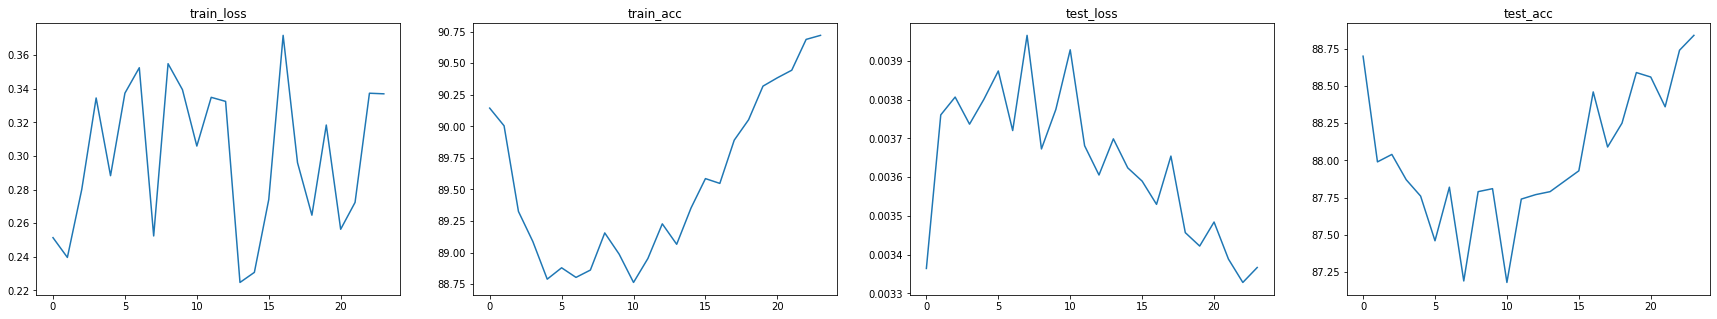

In [ ]:
plot_results(train_losses,train_acc,test_losses,test_acc)

In [44]:
#load the best model from path
resnet18_model = Custom_ResNet()
resnet18_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [45]:
msx_images,msx_labels,msx_predictions = get_image_predictions(model.to('cpu'), test_loader,misclassified = True, count=25)

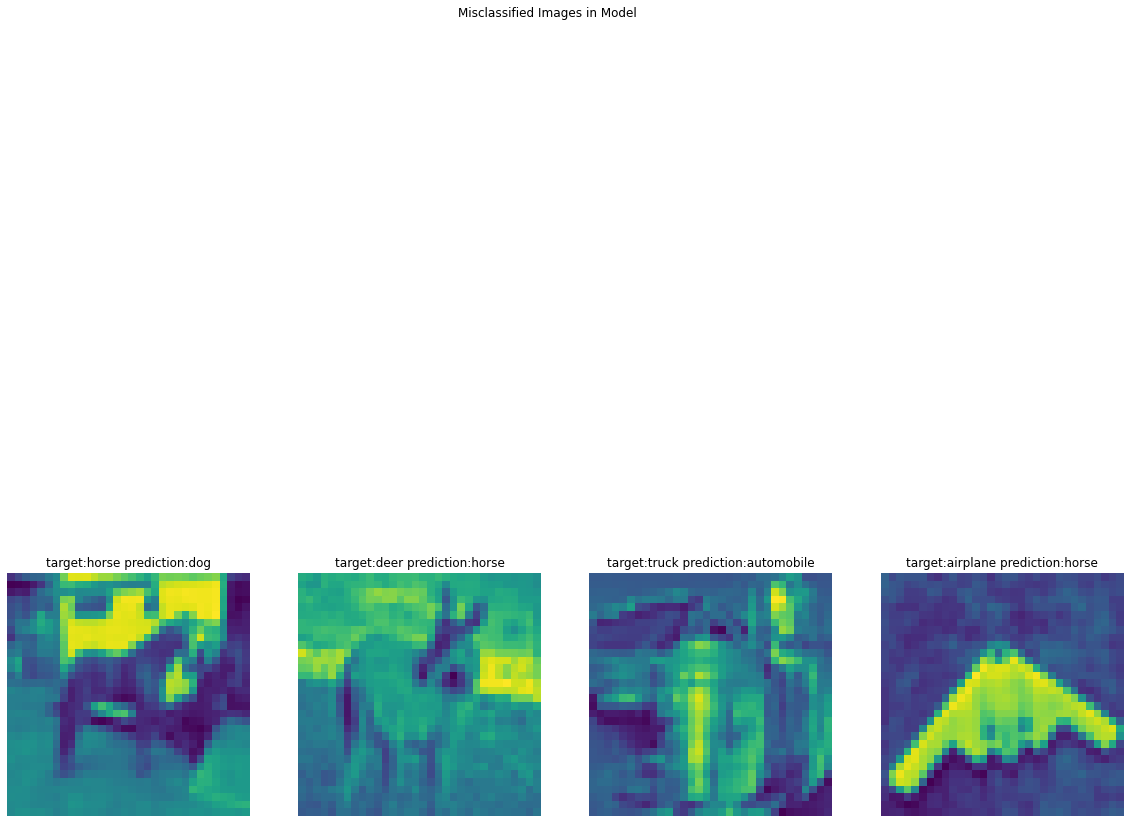

In [46]:
show_images_predictions(msx_images,msx_labels,msx_predictions,classes,nrow=1, ncol=4,fig_size=(20,20))

# Grad CAM

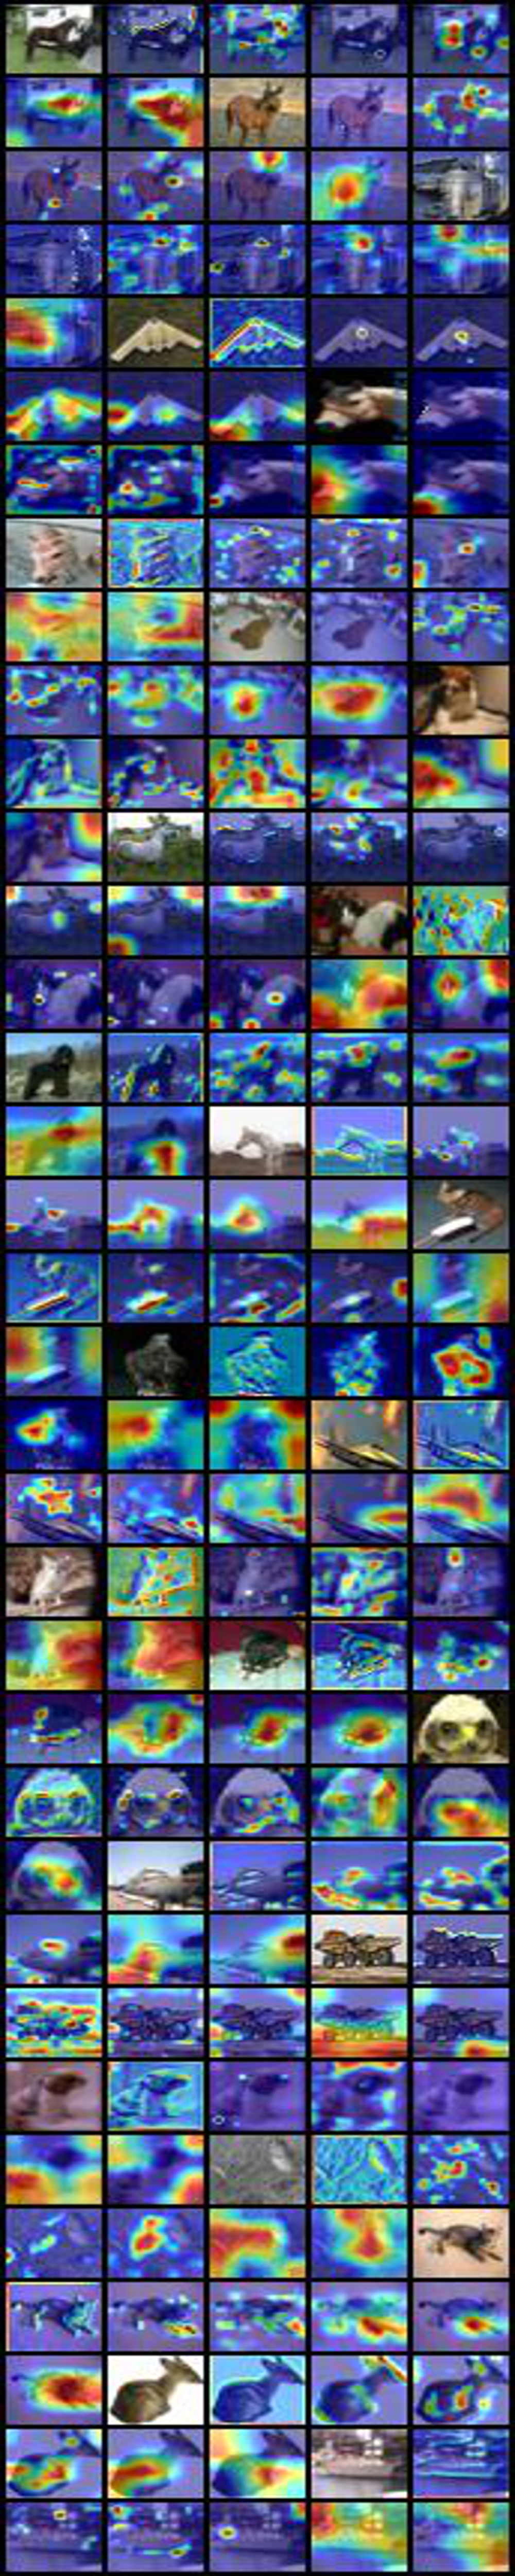

In [47]:
# get the layers in the model
layers = [(module[1][0],module[1][1]) for module in enumerate(model.named_children()) if type(module[1][1]) == torch.nn.modules.container.Sequential]
images = []

#Grad CAM on misclassified images
for idx,image in enumerate(msx_images[0:25]):
  heatmap = {}
  result = {}
  heatmap_pp = {}
  result_pp = {}
  
  noramlized_image = image.unsqueeze(0)#.float().cuda()
  image = denormalize(noramlized_image, mean, std)
  noramlized_image = torch.nn.functional.interpolate(noramlized_image, size=(32, 32), mode='bilinear', align_corners=False)
  #print(image.shape, noramlized_image.shape)

  for layer_name, layer in layers:
      resnet_model_dict = dict(type='resnet', arch=model, layer=layer, input_size=(32, 32),)
      heatmap[layer_name], result[layer_name],heatmap_pp[layer_name], result_pp[layer_name] = get_gradcam(resnet_model_dict, image, noramlized_image, verbose= False)
  images.append(torch.stack([image.squeeze()]+[idx for _,idx in enumerate(result.values())], dim=0))

image_grid = make_grid(torch.cat( images,  ), nrow=5 )
save_image(image_grid, 'grad_cam.jpg')

img = PIL.Image.open('grad_cam.jpg')

img.resize((1000,25*200))

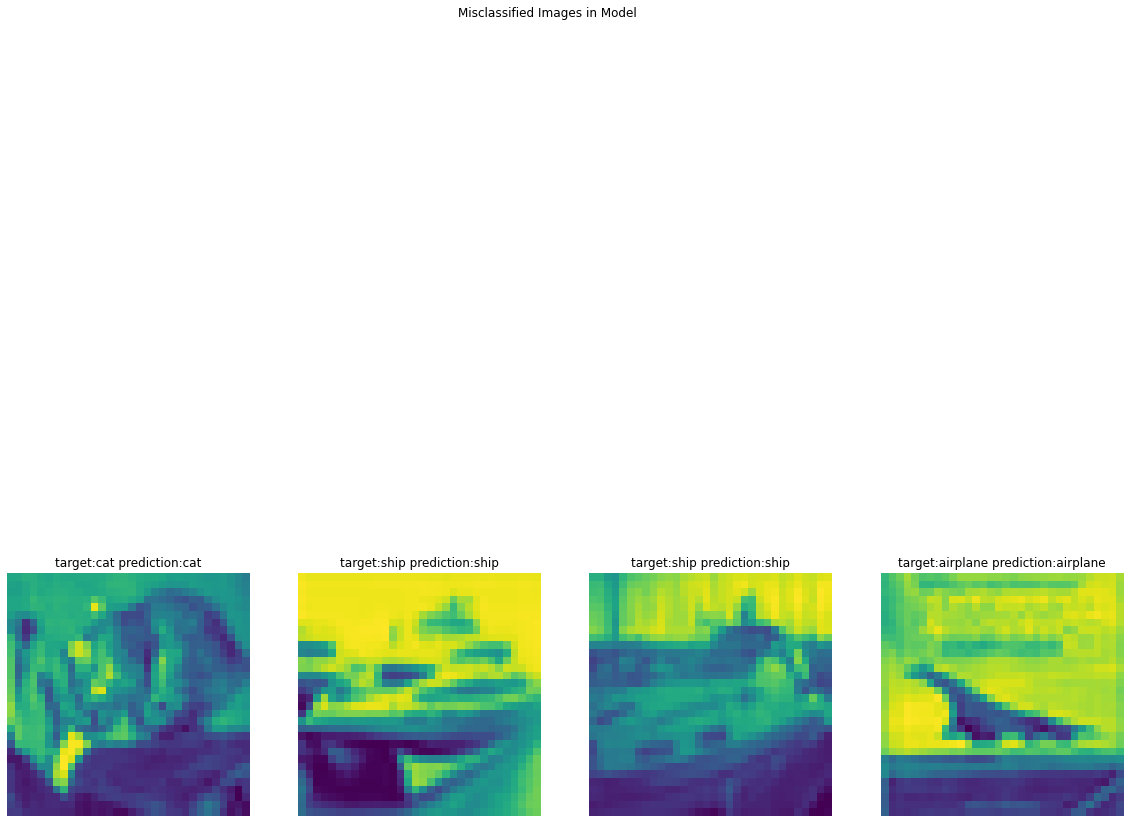

In [48]:
crr_images,crr_labels,crr_predictions = get_image_predictions(model.to('cpu'), test_loader,misclassified = False, count=5) 
show_images_predictions(crr_images,crr_labels,crr_predictions,classes,nrow=1, ncol=4,fig_size=(20,20))

In [49]:
# get the layers in the model
layers = [(module[1][0],module[1][1]) for module in enumerate(model.named_children()) if type(module[1][1]) == torch.nn.modules.container.Sequential]
images = []
for idx,image in enumerate(crr_images[0:5]):
  heatmap = {}
  result = {}
  heatmap_pp = {}
  result_pp = {}
  
  noramlized_image = image.unsqueeze(0)#.float().cuda()
  image = denormalize(noramlized_image, mean, std)
  noramlized_image = torch.nn.functional.interpolate(noramlized_image, size=(32, 32), mode='bilinear', align_corners=False)
  #print(image.shape, noramlized_image.shape)

  for layer_name, layer in layers:
      resnet_model_dict = dict(type='resnet', arch=model, layer=layer, input_size=(32, 32),)
      heatmap[layer_name], result[layer_name],heatmap_pp[layer_name], result_pp[layer_name] = get_gradcam(resnet_model_dict, image, noramlized_image, verbose= False)
  images.append(torch.stack([image.squeeze()]+[idx for _,idx in enumerate(result.values())], dim=0))

image_grid = make_grid(torch.cat( images,  ), nrow=5 )
save_image(image_grid, 'grad_cam2.jpg')

img = PIL.Image.open('grad_cam2.jpg')

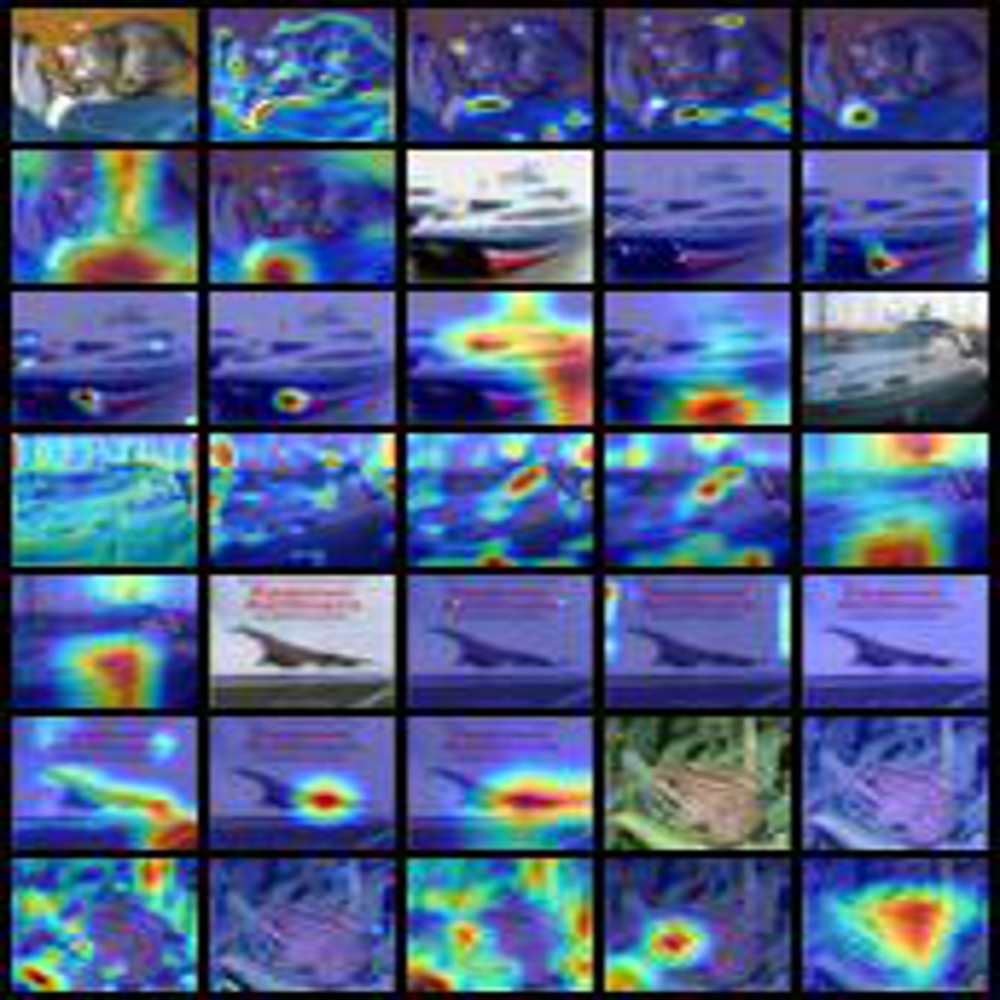

In [50]:
img.resize((1000,5*200))